In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

base_dir = "/content/drive/MyDrive/deepfake_dataset"

# Create a new folder for structured dataset
train_data_path = os.path.join(base_dir, "train_data")
os.makedirs(train_data_path, exist_ok=True)

# Create symlinks
os.symlink(os.path.join(base_dir, "real_frames/real_frames"), os.path.join(train_data_path, "real"))
os.symlink(os.path.join(base_dir, "fake_frames/fake_frames"), os.path.join(train_data_path, "fake"))

print("Symlinks created successfully!")


Symlinks created successfully!


In [8]:
dataset_path = "/content/drive/MyDrive/deepfake_dataset/train_data"

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset with correct path
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into train/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check class labels
print("Class to Index Mapping:", dataset.class_to_idx)


Class to Index Mapping: {'fake': 0, 'real': 1}


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Load Pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modify the last classification layer for binary classification
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1),  # Output 1 neuron (for binary classification)
    nn.Sigmoid()  # Sigmoid for binary probability output
)

# Move model to GPU
model = model.to(device)

Using Device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 96.2MB/s]


In [11]:
# Loss Function: Binary Cross-Entropy (since it's binary classification)
criterion = nn.BCELoss()

# Optimizer: Adam (adjusts learning rate dynamically)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [12]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Trains the model for one epoch"""
    model.train()  # Set to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.float().to(device)  # Move to GPU
        labels = labels.view(-1, 1)  # Reshape for BCE Loss

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Convert probability to binary (0 or 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    """Validates the model on the validation dataset"""
    model.eval()  # Set to evaluation mode
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    return avg_val_loss, val_acc


In [13]:
num_epochs = 10  # Number of epochs
best_val_loss = float("inf")  # Track the best validation loss

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validate after each epoch
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/deepfake_efficientnet_best.pth")
        print("✅ Best model saved!")

print("\nTraining Complete! 🚀")



Epoch 1/10


100%|██████████| 330/330 [20:15<00:00,  3.68s/it]

Train Loss: 0.5131, Accuracy: 0.7293


Validation Loss: 0.4490, Accuracy: 0.7551
✅ Best model saved!

Epoch 2/10


100%|██████████| 330/330 [04:33<00:00,  1.21it/s]

Train Loss: 0.4269, Accuracy: 0.7797


Validation Loss: 0.3926, Accuracy: 0.7908
✅ Best model saved!

Epoch 3/10


100%|██████████| 330/330 [04:25<00:00,  1.24it/s]

Train Loss: 0.3742, Accuracy: 0.8136


Validation Loss: 0.3602, Accuracy: 0.8178
✅ Best model saved!

Epoch 4/10


100%|██████████| 330/330 [04:25<00:00,  1.24it/s]

Train Loss: 0.3228, Accuracy: 0.8448


Validation Loss: 0.3318, Accuracy: 0.8314
✅ Best model saved!

Epoch 5/10


100%|██████████| 330/330 [04:24<00:00,  1.25it/s]

Train Loss: 0.2887, Accuracy: 0.8624


Validation Loss: 0.3150, Accuracy: 0.8440
✅ Best model saved!

Epoch 6/10


100%|██████████| 330/330 [04:31<00:00,  1.22it/s]

Train Loss: 0.2584, Accuracy: 0.8788


Validation Loss: 0.2799, Accuracy: 0.8599
✅ Best model saved!

Epoch 7/10


100%|██████████| 330/330 [04:28<00:00,  1.23it/s]

Train Loss: 0.2251, Accuracy: 0.8947


Validation Loss: 0.2877, Accuracy: 0.8569

Epoch 8/10


100%|██████████| 330/330 [04:25<00:00,  1.24it/s]

Train Loss: 0.1895, Accuracy: 0.9127


Validation Loss: 0.2913, Accuracy: 0.8713

Epoch 9/10


100%|██████████| 330/330 [04:20<00:00,  1.27it/s]

Train Loss: 0.1760, Accuracy: 0.9248


Validation Loss: 0.3093, Accuracy: 0.8648

Epoch 10/10


100%|██████████| 330/330 [04:30<00:00,  1.22it/s]

Train Loss: 0.1509, Accuracy: 0.9332


Validation Loss: 0.3116, Accuracy: 0.8717

Training Complete! 🚀


In [18]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define test data path
test_data_path = "/content/drive/MyDrive/deepfake_dataset/train_data"  # Change if using a separate test dataset

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load test dataset
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = models.efficientnet_b0(pretrained=False)  # Initialize model
num_ftrs = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 1),
    torch.nn.Sigmoid()
)

# Load trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_efficientnet_best.pth", map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

# Initialize lists for evaluation
y_true = []
y_pred = []
y_scores = []  # Stores probabilities for ROC-AUC calculation

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        probabilities = outputs.cpu().numpy().flatten()  # Convert to NumPy array
        predicted_classes = (outputs > 0.5).cpu().numpy().astype(int).flatten()  # Threshold at 0.5

        # Store true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted_classes)
        y_scores.extend(probabilities)  # Store probability for ROC-AUC

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Print Classification Report
print("\n📌 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Print Confusion Matrix
print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_scores)
print(f"\n📌 ROC-AUC Score: {roc_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-18-833ff938fbdf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

✅ Test Accuracy: 90.36%

📌 Classification Report:
              precision    recall  f1-score   support

        Fake       0.85      0.96      0.90      6019
        Real       0.97      0.85      0.91      7150

    accuracy                           0.90     13169
   macro avg       0.91      0.91      0.90     13169
weighted avg       0.91      0.90      0.90     13169


📌 Confusion Matrix:
[[5802  217]
 [1053 6097]]

📌 ROC-AUC Score: 0.9748


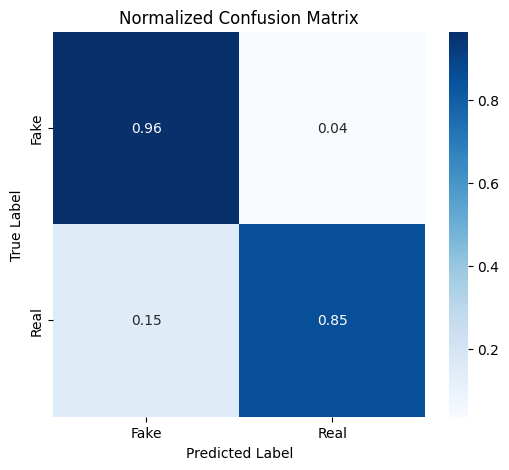

✅ Normalized Confusion Matrix saved as normalized_confusion_matrix.png


In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")  # Normalized per row

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.savefig("/content/drive/MyDrive/normalized_confusion_matrix.png")
plt.show()

print("✅ Normalized Confusion Matrix saved as normalized_confusion_matrix.png")


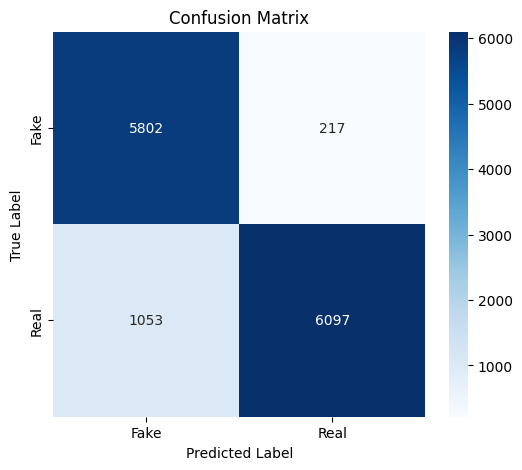

✅ Confusion Matrix saved as confusion_matrix.png


In [20]:
# Compute Confusion Matrix (Standard)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("/content/drive/MyDrive/confusion_matrix.png")
plt.show()

print("✅ Confusion Matrix saved as confusion_matrix.png")


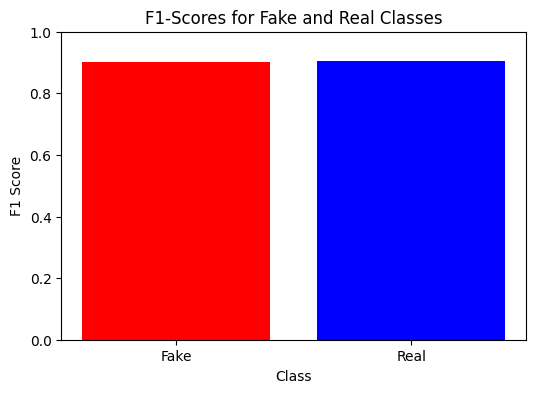

✅ F1 Curve saved as f1_curve.png


In [21]:
# Extract F1-scores
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=["Fake", "Real"], output_dict=True)
f1_scores = [report["Fake"]["f1-score"], report["Real"]["f1-score"]]
labels = ["Fake", "Real"]

plt.figure(figsize=(6, 4))
plt.bar(labels, f1_scores, color=["red", "blue"])
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("F1-Scores for Fake and Real Classes")
plt.ylim(0, 1)
plt.savefig("/content/drive/MyDrive/f1_curve.png")
plt.show()

print("✅ F1 Curve saved as f1_curve.png")


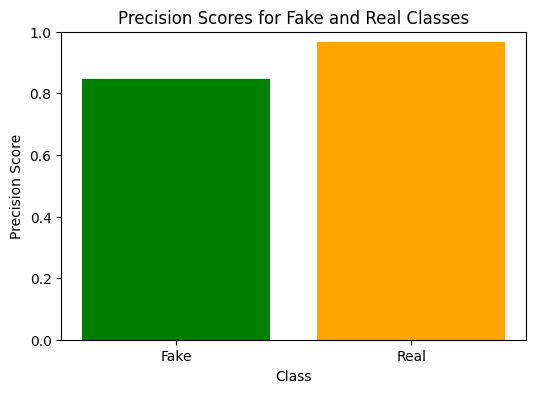

✅ Precision Curve saved as p_curve.png


In [22]:
# Extract Precision Scores
precision_scores = [report["Fake"]["precision"], report["Real"]["precision"]]

plt.figure(figsize=(6, 4))
plt.bar(labels, precision_scores, color=["green", "orange"])
plt.xlabel("Class")
plt.ylabel("Precision Score")
plt.title("Precision Scores for Fake and Real Classes")
plt.ylim(0, 1)
plt.savefig("/content/drive/MyDrive/p_curve.png")
plt.show()

print("✅ Precision Curve saved as p_curve.png")


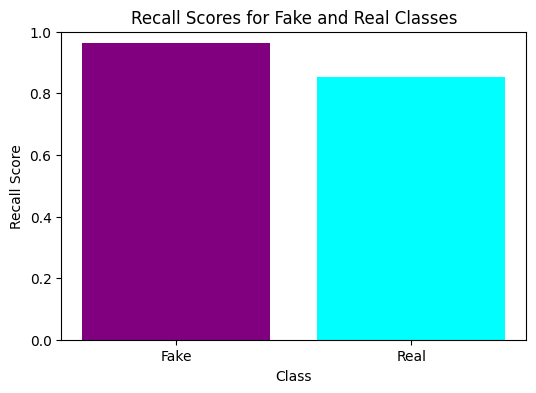

✅ Recall Curve saved as r_curve.png


In [23]:
# Extract Recall Scores
recall_scores = [report["Fake"]["recall"], report["Real"]["recall"]]

plt.figure(figsize=(6, 4))
plt.bar(labels, recall_scores, color=["purple", "cyan"])
plt.xlabel("Class")
plt.ylabel("Recall Score")
plt.title("Recall Scores for Fake and Real Classes")
plt.ylim(0, 1)
plt.savefig("/content/drive/MyDrive/r_curve.png")
plt.show()

print("✅ Recall Curve saved as r_curve.png")


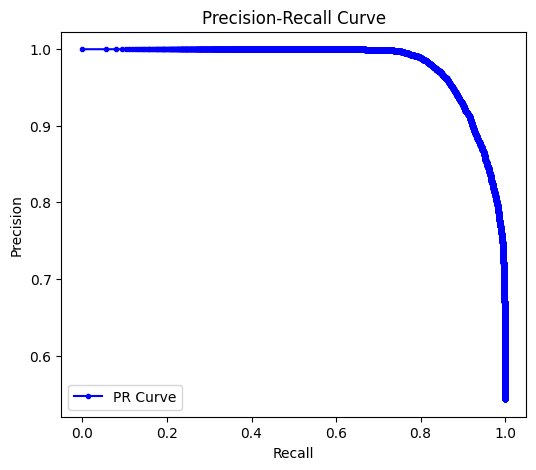

✅ PR Curve saved as pr_curve.png


In [24]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker=".", color="blue", label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig("/content/drive/MyDrive/pr_curve.png")
plt.show()

print("✅ PR Curve saved as pr_curve.png")


In [25]:
import pandas as pd

# Save classification report as CSV
df_results = pd.DataFrame(report).transpose()
df_results.to_csv("/content/drive/MyDrive/results.csv", index=True)

print("✅ Results saved as results.csv")


✅ Results saved as results.csv


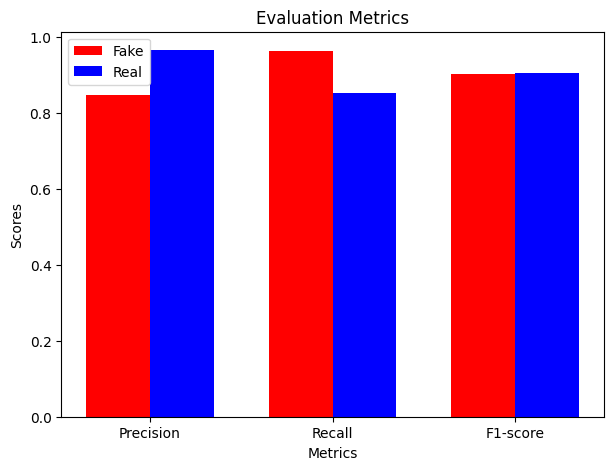

✅ Results Plot saved as results.png


In [26]:
metrics = ["Precision", "Recall", "F1-score"]
fake_metrics = [report["Fake"]["precision"], report["Fake"]["recall"], report["Fake"]["f1-score"]]
real_metrics = [report["Real"]["precision"], report["Real"]["recall"], report["Real"]["f1-score"]]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, fake_metrics, width, label="Fake", color="red")
bars2 = ax.bar(x + width/2, real_metrics, width, label="Real", color="blue")

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Evaluation Metrics")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig("/content/drive/MyDrive/results.png")
plt.show()

print("✅ Results Plot saved as results.png")
